# Layers

Common model layers.

In [ ]:
#| default_exp models.layers

In [ ]:
#| export
from genQC.imports import *

## Basic scaling blocks

In [ ]:
#| export
class DownBlock2D(nn.Module):  
    """A 2d down scale block."""
    def __init__(self, in_ch, out_ch, kernel_size=2, stride=2, padding=0, use_conv=True):
        super().__init__()  
        self.use_conv = use_conv                
        if self.use_conv: 
            self.conv1  = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding)           
        else:       
            self.avg_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=padding)    
            self.convId   = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding="same") if in_ch!=out_ch else nn.Identity()   
        
    def forward(self, x):               
        if self.use_conv:
            #x = F.pad(x, pad=(0,0,0,1), mode="constant", value=0) #for 2d: pad=(0,1,0,1)
            x = self.conv1(x)          
        else:
            x = self.avg_pool(x)
            x = self.convId(x)           
        return x

In [ ]:
#| export
class UpBlock2D(nn.Module):  
    """A 2d up scale block."""
    def __init__(self, in_ch, out_ch, kernel_size=2, stride=2, padding=0, use_conv=True):
        super().__init__()  
        self.use_conv  = use_conv                 
        self.up_sample = nn.Upsample(scale_factor=kernel_size)           
        if self.use_conv: 
            self.conv1  = nn.Conv2d(in_ch, out_ch, kernel_size=(1,3), stride=1, padding="same")  
        else:             
            self.convId = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding="same") if in_ch!=out_ch else nn.Identity()   
            
    def forward(self, x):        
        x = self.up_sample(x)       
        if self.use_conv: 
            x = self.conv1(x)          
        else:             
            x = self.convId(x)                
        return x

In [ ]:
#| hide
#| export
class ResDownBlock2D(nn.Module):  
    """A 2d residual down scale block."""
    def __init__(self, in_ch, out_ch, kernel_size=2, stride=2, padding=0):
        super().__init__()     
        self.act    = nn.SiLU() 
        self.conv1  = nn.Conv2d( in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding) 
        self.norm   = torch.nn.GroupNorm(num_groups=16, num_channels=out_ch, eps=1e-5, affine=True)        
        self.convId = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding="same") if in_ch!=out_ch else lambda x:x
        self.down   = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
               
    def forward(self, x):         
        r1 = self.conv1(x)
        r1 = self.norm(r1)
        r1 = self.act(r1)
        
        r2 = self.convId(x)
        r2 = self.down(r2)
        return self.act(r1 + r2)

In [ ]:
#| hide
#| export
class ResUpBlock2D(nn.Module):  
    """A 2d residual up scale block."""
    def __init__(self, in_ch, out_ch, kernel_size=2, stride=2, padding=0):
        super().__init__()     
        self.act    = nn.SiLU()
        self.conv1  = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding) 
        self.norm   = torch.nn.GroupNorm(num_groups=16, num_channels=out_ch, eps=1e-6, affine=True)        
        self.convId = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding="same") if in_ch!=out_ch else nn.Identity()
        self.up     = nn.Upsample(scale_factor=kernel_size)
               
    def forward(self, x):         
        r1 = self.conv1(x)
        r1 = self.norm(r1)
        r1 = self.act(r1)
        
        r2 = self.convId(x)
        r2 = self.up(r2)
        return self.act(r1 + r2)

## ResNet blocks

In [ ]:
#| export
class ResBlock2D(nn.Module):
    """A 2d residual block."""
    def __init__(self, in_ch, out_ch, kernel_size, skip=True):
        super().__init__()             
        self.act   = nn.SiLU()             
        self.conv1 = nn.Conv2d( in_ch, out_ch, kernel_size=kernel_size, stride=1, padding ="same")        
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding ="same")
        
        self.norm1  = torch.nn.GroupNorm(num_groups=32, num_channels=in_ch) #, eps=1e-6, affine=True)         
        self.norm2  = torch.nn.GroupNorm(num_groups=32, num_channels=out_ch) #, eps=1e-6, affine=True)  
        
        self.skip  = skip 
        if self.skip:        
            self.skip_connection= nn.Conv2d(in_ch,  out_ch, kernel_size=1, stride=1, padding ="same") if in_ch!=out_ch else nn.Identity()
         
    def forward(self, x):      
        
        #in layers
        h = self.norm1(x) 
        h = self.act(h)
        h = self.conv1(h)  
        
        #out layers
        h = self.norm2(h) 
        h = self.act(h)
        h = self.conv2(h)
    
        #----
    
        if not self.skip: return h  
                   
        return self.skip_connection(x) + h

In [ ]:
#| export
class ResBlock2D_Conditional(nn.Module):
    """A 2d residual block with input of a time-step $t$ embedding."""
    def __init__(self, in_ch, out_ch, t_emb_size, kernel_size, skip=True):
        super().__init__()             
        self.act   = nn.SiLU()             
        self.conv1 = nn.Conv2d( in_ch, out_ch, kernel_size=kernel_size, stride=1, padding ="same")        
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding ="same")
        
        self.norm1  = torch.nn.GroupNorm(num_groups=32, num_channels=in_ch) #, eps=1e-6, affine=True)         
        self.norm2  = torch.nn.GroupNorm(num_groups=32, num_channels=out_ch) #, eps=1e-6, affine=True)  
        
        self.skip  = skip 
        if self.skip:        
            self.skip_connection= nn.Conv2d(in_ch,  out_ch, kernel_size=1, stride=1, padding ="same") if in_ch!=out_ch else nn.Identity()
        
        self.t_proj = nn.Linear(t_emb_size, out_ch)    
               
    def forward(self, x, t_emb):      
        
        #in layers
        h = self.norm1(x) 
        h = self.act(h)
        h = self.conv1(h)  
        
        #embed
        h = h + self.t_proj(t_emb)[:, :, None, None]
        
        #out layers
        h = self.norm2(h) 
        h = self.act(h)
        h = self.conv2(h)
    
        #----
    
        if not self.skip: return h  
                   
        return self.skip_connection(x) + h

## FeedForward layer

In [ ]:
#| export
class FeedForward(nn.Module):
    """A small dense feed-forward network as used in `transformers`."""
    def __init__(self, in_ch, out_ch, inner_mult=1):
        super().__init__()
        self.proj1 = nn.Linear(in_ch, in_ch*inner_mult)   
        self.proj2 = nn.Linear(in_ch*inner_mult, out_ch) 
        self.act   = nn.SiLU()
        
    def forward(self, x):
        x = self.proj1(x)
        x = self.act(x)
        x = self.proj2(x) 
        return x     

## Position embedding layers

Create sinusoidal position embeddings, same as those from the `transformer`:

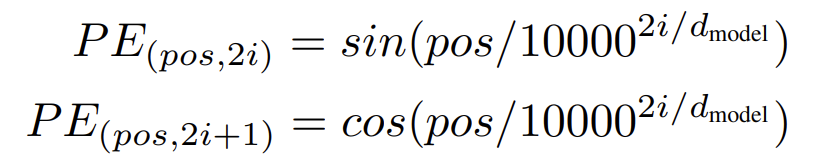

In [ ]:
#| export
class PositionalEncoding(nn.Module):
    """An absolute pos encoding layer."""
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len , embedding_dim]``
        """
        x = x + self.pe[None, :x.size(1)]
        return self.dropout(x)

In [ ]:
#| export
class TimeEmbedding(PositionalEncoding):
    """A time embedding layer"""
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__(d_model, dropout, max_len)             
        self.ff = FeedForward(d_model, d_model)  
       
    def forward(self, t: torch.Tensor):       
        x = self.pe[t]       
        x = self.ff(x)               
        return self.dropout(x)

In [ ]:
#| export
class PositionalEncodingTransposed(PositionalEncoding):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__(d_model, dropout, max_len)        
        self.pe = torch.permute(self.pe, (1, 0)) # [max_len, d_model] to [d_model, max_len]
               
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, embedding_dim, seq_len]``
        """
        x = x + self.pe[None, :, :x.size(2)]
        return self.dropout(x)

In [ ]:
#| export
class PositionalEncoding2D(PositionalEncodingTransposed):
    """A 2D absolute pos encoding layer."""
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__(d_model=d_model//2, dropout=dropout, max_len=max_len)    
        self.d_model_half = d_model//2    
        # self.proj         = nn.Conv2d(d_model, d_model, kernel_size=1, stride=1, padding ="same")      
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, gate_color, space , time]``
        """
                                          
        p1 = self.pe[None, :, :x.size(2),       None] #space encoding
        p2 = self.pe[None, :,       None, :x.size(3)] #time encoding 
                                
        x[:, :self.d_model_half] = x[:, :self.d_model_half] + p1
        x[:, self.d_model_half:] = x[:, self.d_model_half:] + p2
        
        # x = self.proj(x)
        
        return self.dropout(x)

In [ ]:
#| hide
#| export
class PositionalEncoding2DSpaceOnly(PositionalEncodingTransposed):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__(d_model=d_model, dropout=dropout, max_len=max_len)      
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, gate_color, space , time]``
        """
                                          
        p1 = self.pe[None, :, :x.size(2), None] #space encoding        
        return self.dropout(x + p1)

In [ ]:
a = torch.zeros((1, 4, 3, 4))
l = PositionalEncoding2D(d_model=4)   

l(a)[0].shape

torch.Size([4, 3, 4])

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()